In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test_unknown_data_path = './data/3_rf_test_unknown_data_v2.csv'
test_unknown_data = pd.read_csv(test_unknown_data_path)

test_unknown_label_path = './data/3_rf_test_unknown_label_v2.csv'
test_unknown_label = pd.read_csv(test_unknown_label_path)

test = './data/testing_data.csv'
test_data = pd.read_csv(test)

test_L= './data/testing_lable.csv'
test_L_data  = pd.read_csv(test_L)

In [3]:
import pickle

In [4]:
with open('./data/5_gan_data_v1_1.pkl', 'rb') as file:
    gan_data_v1 = pickle.load(file)
with open('./data/5_gan_label_v1_1.pkl', 'rb') as file:
    gan_label_v1 = pickle.load(file)
with open('./data/5_gan_data_v1_2.pkl', 'rb') as file:
    gan_data_v1a = pickle.load(file)
with open('./data/5_gan_label_v1_2.pkl', 'rb') as file:
    gan_label_v1a = pickle.load(file)

In [5]:
with open('./data/5_gan_data_v2_1.pkl', 'rb') as file:
    gan_data_v2 = pickle.load(file)
with open('./data/5_gan_label_v2_1.pkl', 'rb') as file:
    gan_label_v2 = pickle.load(file)
with open('./data/5_gan_data_v2_2.pkl', 'rb') as file:
    gan_data_v2a = pickle.load(file)
with open('./data/5_gan_label_v2_2.pkl', 'rb') as file:
    gan_label_v2a = pickle.load(file)

In [6]:
with open('./data/class_mapping.pkl', 'rb') as file:
    class_mapping = pickle.load(file)

In [7]:
class_mapping

{'Backdoor_Malware': 0,
 'BenignTraffic': 1,
 'BrowserHijacking': 2,
 'CommandInjection': 3,
 'DDoS-ACK_Fragmentation': 4,
 'DDoS-HTTP_Flood': 5,
 'DDoS-ICMP_Flood': 6,
 'DDoS-ICMP_Fragmentation': 7,
 'DDoS-PSHACK_Flood': 8,
 'DDoS-RSTFINFlood': 9,
 'DDoS-SYN_Flood': 10,
 'DDoS-SlowLoris': 11,
 'DDoS-SynonymousIP_Flood': 12,
 'DDoS-TCP_Flood': 13,
 'DDoS-UDP_Flood': 14,
 'DDoS-UDP_Fragmentation': 15,
 'DNS_Spoofing': 16,
 'DictionaryBruteForce': 17,
 'DoS-HTTP_Flood': 18,
 'DoS-SYN_Flood': 19,
 'DoS-TCP_Flood': 20,
 'DoS-UDP_Flood': 21,
 'MITM-ArpSpoofing': 22,
 'Mirai-greeth_flood': 23,
 'Mirai-greip_flood': 24,
 'Mirai-udpplain': 25,
 'Recon-HostDiscovery': 26,
 'Recon-OSScan': 27,
 'Recon-PingSweep': 28,
 'Recon-PortScan': 29,
 'SqlInjection': 30,
 'Uploading_Attack': 31,
 'VulnerabilityScan': 32,
 'XSS': 33}

In [8]:
# flip the dictionary. key into value, and vice versa
flipped_dict = dict((v, k) for k, v in class_mapping.items())

In [9]:
gan_label_v1 = pd.DataFrame(gan_label_v1)
gan_label_v2 = pd.DataFrame(gan_label_v2)
gan_label_v1a = pd.DataFrame(gan_label_v1)
gan_label_v2a = pd.DataFrame(gan_label_v2)

In [10]:
gan_label_v1

,label
0,1
1,1
2,1
3,1
4,1
...,...
16872,8
16873,7
16874,7
16875,4


In [11]:
gan_label_v1['label'] = gan_label_v1['label'].replace(flipped_dict)
gan_label_v2['label'] = gan_label_v2['label'].replace(flipped_dict)
gan_label_v1a['label'] = gan_label_v1a['label'].replace(flipped_dict)
gan_label_v2a['label'] = gan_label_v2a['label'].replace(flipped_dict)

In [12]:
gan_label_v1['label'].value_counts()
gan_label_v1a['label'].value_counts()

label
BenignTraffic              15119
DDoS-PSHACK_Flood            768
DDoS-ICMP_Fragmentation      515
DDoS-ACK_Fragmentation       348
DDoS-HTTP_Flood               52
DDoS-RSTFINFlood              39
BrowserHijacking              12
CommandInjection               7
Backdoor_Malware               6
DDoS-SlowLoris                 6
DDoS-ICMP_Flood                5
Name: count, dtype: int64

In [13]:
attacks = ['DDoS', 'DoS', 'Mirai', 'Recon']

def mergeAttacks(dataframe, attacks):
    """ Merge attacks into big category

    Args:
        dataframe(Pandas dataframe): Contains specific attacks

    Return:
        (Pandas dataframe): merged dataframe
    """

    dataframe.loc[dataframe['label'].str.contains('DDoS'), 'label'] = 'andrew-nah'

    for attack in attacks:
        if attack == 'DDoS':
            continue
        dataframe.loc[dataframe['label'].str.contains(attack), 'label'] = attack
    
    dataframe.loc[dataframe['label'].str.contains('andrew-nah'), 'label'] = 'DDoS'
    
    return dataframe

# Merge attacks in syntesized data

In [14]:
gan_label_v1 = mergeAttacks(gan_label_v1, attacks)
gan_label_v2 = mergeAttacks(gan_label_v2, attacks)
gan_label_v1a = mergeAttacks(gan_label_v1a, attacks)
gan_label_v2a = mergeAttacks(gan_label_v2a, attacks)

# Drop the major attacks; DDoS, DoS, Mirai

In [15]:
def dropMajor(data, label):
    """ Drop the designated attacks

    Args:
        data(Pandas dataframe): data without labels
        label(Pandas dataframe): corresponding labels to data

    Return:
        (Pandas dataframe): dataframe without designated attacks

    """
    df = pd.concat([data, label], axis=1)
    df_filtered = df.drop(df[df['label'].isin(['BenignTraffic'])].index)
    return df_filtered


In [16]:
gan_dropped_v1 = dropMajor(gan_data_v1, gan_label_v1)
gan_dropped_v2 = dropMajor(gan_data_v2, gan_label_v2)
gan_dropped_v1a = dropMajor(gan_data_v1a, gan_label_v1a)
gan_dropped_v2a = dropMajor(gan_data_v2a, gan_label_v2a)

In [17]:
gan_dropped_v1['label'].value_counts()
gan_dropped_v1a['label'].value_counts()

label
DDoS                1733
BrowserHijacking      12
CommandInjection       7
Backdoor_Malware       6
Name: count, dtype: int64

In [18]:
gan_dropped_v2['label'].value_counts()
gan_dropped_v2a['label'].value_counts()

label
DDoS                593
BrowserHijacking      4
CommandInjection      4
Backdoor_Malware      2
Name: count, dtype: int64

In [19]:
gan_dropped_data_v1 = gan_dropped_v1.drop(columns=['label'])
gan_dropped_label_v1 = pd.DataFrame(gan_dropped_v1['label'])
gan_dropped_data_v2 = gan_dropped_v2.drop(columns=['label'])
gan_dropped_label_v2 = pd.DataFrame(gan_dropped_v2['label'])
gan_dropped_data_v1a = gan_dropped_v1a.drop(columns=['label'])
gan_dropped_label_v1a = pd.DataFrame(gan_dropped_v1a['label'])
gan_dropped_data_v2a = gan_dropped_v2a.drop(columns=['label'])
gan_dropped_label_v2a = pd.DataFrame(gan_dropped_v2a['label'])

# Merge original and synthesized data together

In [20]:
gan_merged_data = pd.concat([gan_dropped_data_v1,gan_dropped_data_v2], axis=0)
gan_merged_label = pd.concat([gan_dropped_label_v1, gan_dropped_label_v2], axis=0)
gan_merged_data2 = pd.concat([gan_dropped_data_v1a,gan_dropped_data_v2a], axis=0)
gan_merged_label2 = pd.concat([gan_dropped_label_v1a, gan_dropped_label_v2a], axis=0)
gan_data = pd.concat([gan_merged_data,gan_merged_data2], axis=0)
gan_label = pd.concat([gan_merged_label, gan_merged_label2], axis=0)
train_data = pd.concat([gan_data,test_unknown_data], axis=0)
train_label = pd.concat([gan_label, test_unknown_label], axis=0)

In [21]:
train_label.value_counts()

label               
BenignTraffic           5062
DDoS                    4652
Recon                    258
MITM-ArpSpoofing         191
DNS_Spoofing             135
BrowserHijacking          36
CommandInjection          25
DictionaryBruteForce      21
Backdoor_Malware          19
SqlInjection              11
XSS                        2
VulnerabilityScan          1
Name: count, dtype: int64

In [22]:
# Display column names
print("Column names:")
print(train_data.columns)

# Display dataset shape
print("\nDataset shape:")
print(train_data.shape)


Column names:
Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight'],
      dtype='object')

Dataset shape:
(10416, 46)


In [23]:
# Print data types
print("\nData Types:")
print(train_data.dtypes)


Data Types:
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC                float64
Tot sum            float64
Min                float64
Max                float64
AVG            

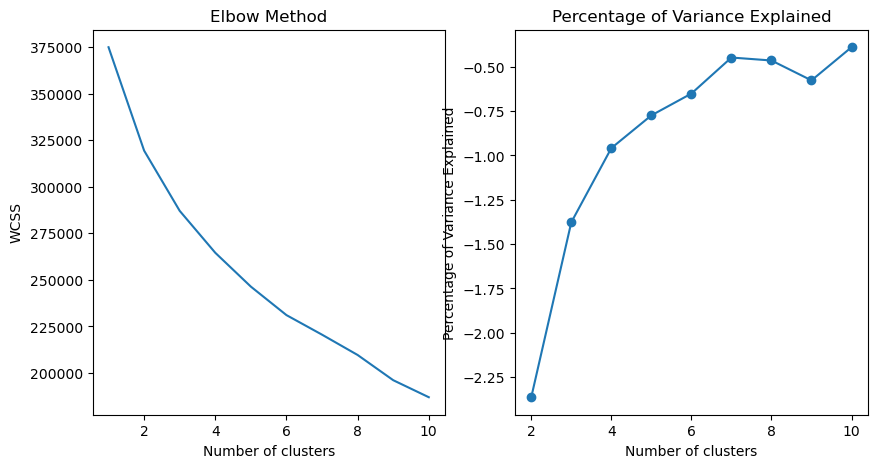

In [24]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming 'test_unknown_data' is your dataset
data = train_data

# Step 4: Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Step 5: Choose the Number of Clusters (K)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Calculate the percentage of variance explained
percentage_var_explained = np.diff(wcss) / np.sum(wcss[:-1]) * 100

# Plotting the elbow graph with the percentage of variance explained
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), percentage_var_explained, marker='o')
plt.title('Percentage of Variance Explained')
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of Variance Explained')
plt.show()


Silhouette Score: 0.25534818853402225


C:\Users\aravi\AppData\Local\Temp\ipykernel_13288\3889470198.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(range(len(test_cluster_labels)), test_cluster_labels, cmap='viridis', marker='o')


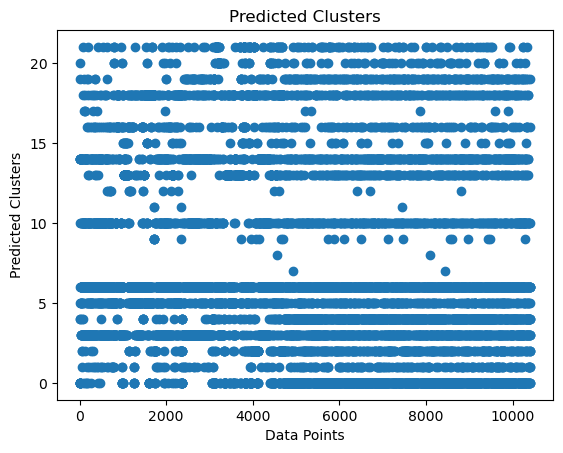

In [25]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Drop the 'Cluster' column if it exists
data_for_scaling = data.drop('Cluster', axis=1, errors='ignore')

# Step 4: Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_scaling)

# Manually set the optimal number of clusters based on the elbow method
your_optimal_k = 22

# Fit K-Means model to the training data
kmeans = KMeans(n_clusters=your_optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=2)
kmeans.fit(scaled_data)

# Assuming your test data has the same features as the training data
scaled_test_data = scaler.transform(data_for_scaling)

# Predict the clusters for the test data
test_cluster_labels = kmeans.predict(scaled_test_data)

# Silhouette Score for clustering evaluation
silhouette_avg = silhouette_score(scaled_test_data, test_cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Plotting predicted clusters
plt.scatter(range(len(test_cluster_labels)), test_cluster_labels, cmap='viridis', marker='o')
plt.xlabel('Data Points')
plt.ylabel('Predicted Clusters')
plt.title('Predicted Clusters')
plt.show()


c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


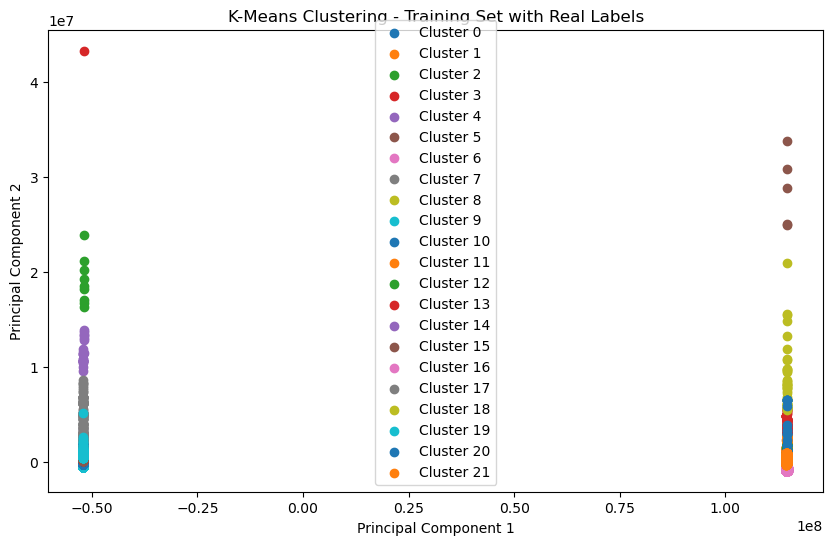

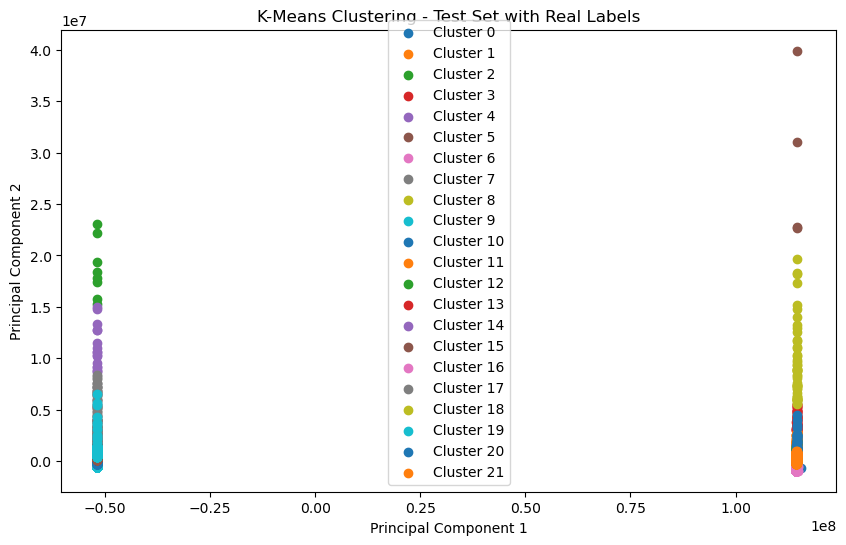

In [26]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import numpy as np


X = train_data
y = train_label['label'] 

# Apply label encoding to the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train = X
y_train = y

X_test = test_data
y_test = test_L_data

# Specify the number of clusters
number_of_clusters = 22

# Apply k-means clustering on the training set
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
train_predicted_labels = kmeans.fit_predict(X_train)

# Apply the clustering model to the test set
test_predicted_labels = kmeans.predict(X_test)

# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Scatter plot for training set with real labels
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (train_predicted_labels == cluster)
    plt.scatter(X_train_reduced[cluster_mask, 0], X_train_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Training Set with Real Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Scatter plot for test set with real labels
plt.figure(figsize=(10, 6))
for cluster in range(number_of_clusters):
    cluster_mask = (test_predicted_labels == cluster)
    plt.scatter(X_test_reduced[cluster_mask, 0], X_test_reduced[cluster_mask, 1], label=f'Cluster {cluster}')

plt.title('K-Means Clustering - Test Set with Real Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Number of NaN elements in X_pca_train: 0


c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia (Model 5): 103298.68148145225
Silhouette Score (Model 5): -0.8438378672078011
Calinski-Harabasz Index (Model 5): 69.62438657959811
Davies-Bouldin Index (Model 5): 21.084920939390685


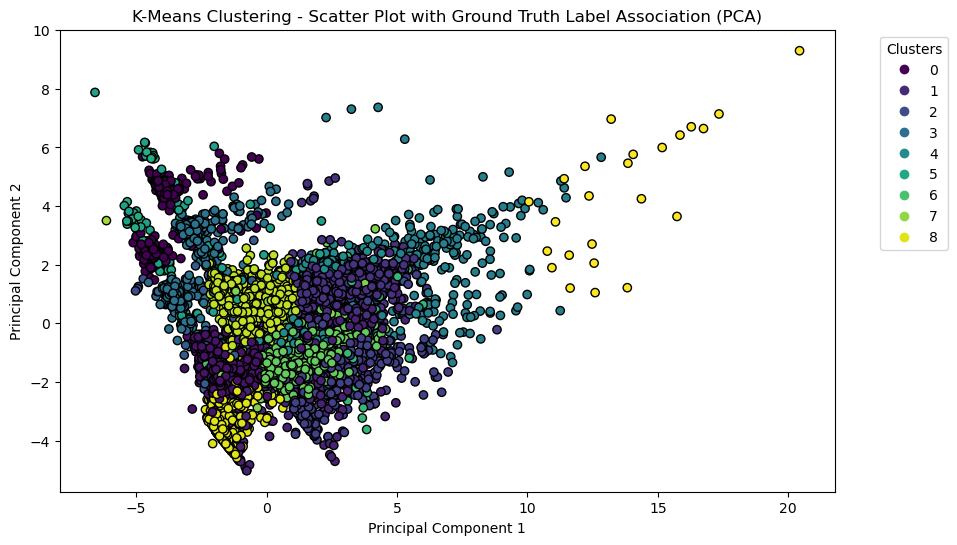

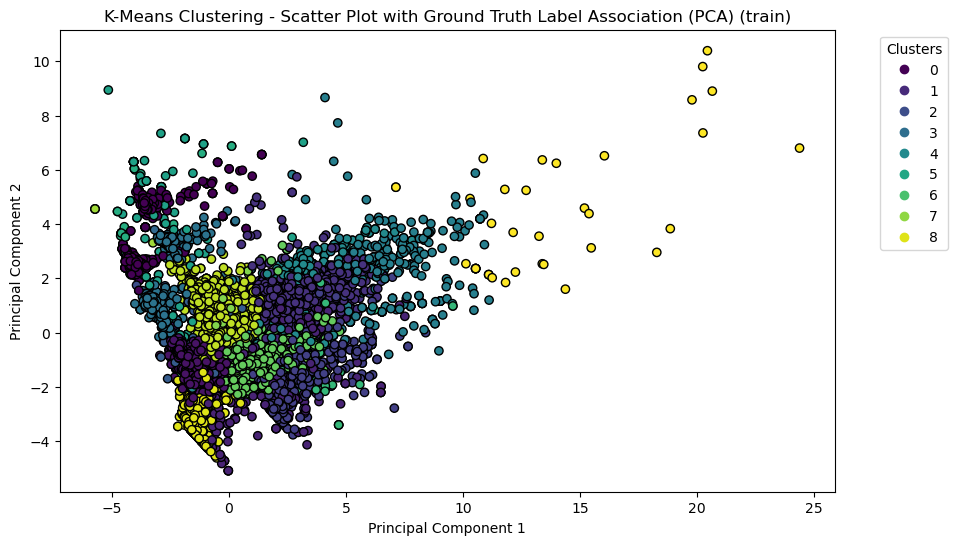

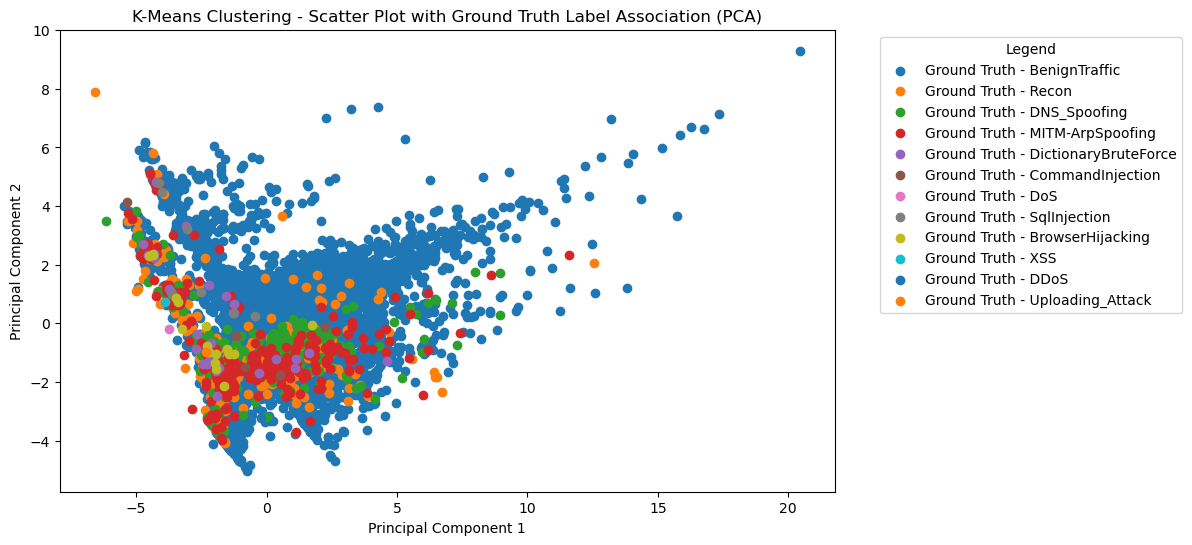

20832
20832
Label: DDoS, Indices: Index([6108, 6109, 6110, 6111, 6112, 6114, 6115, 6116, 6117, 6118,
       ...
       5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630],
      dtype='int64', length=2036), X_pca_train shape: (10416, 2)
Label: BrowserHijacking, Indices: Index([8377, 9955, 2927, 3305, 4499, 4695, 8377, 9955, 2927, 3305, 4499, 4695,
        720, 1893, 3345, 4968],
      dtype='int64'), X_pca_train shape: (10416, 2)
Label: Backdoor_Malware, Indices: Index([4296, 5211, 4296, 5211, 38, 57, 1770], dtype='int64'), X_pca_train shape: (10416, 2)
Label: CommandInjection, Indices: Index([5169, 5356, 5462, 5595, 5169, 5356, 5462, 5595, 287, 4643, 5169], dtype='int64'), X_pca_train shape: (10416, 2)
Label: nan, Indices: Index([], dtype='int64'), X_pca_train shape: (10416, 2)
Label: BenignTraffic, Indices: Index([   0,    1,    2,    3,    4,    6,    7,    8,    9,   11,
       ...
       5680, 5681, 5682, 5683, 5684, 5685, 5686, 5688, 5689, 5690],
      dtype='int64', leng

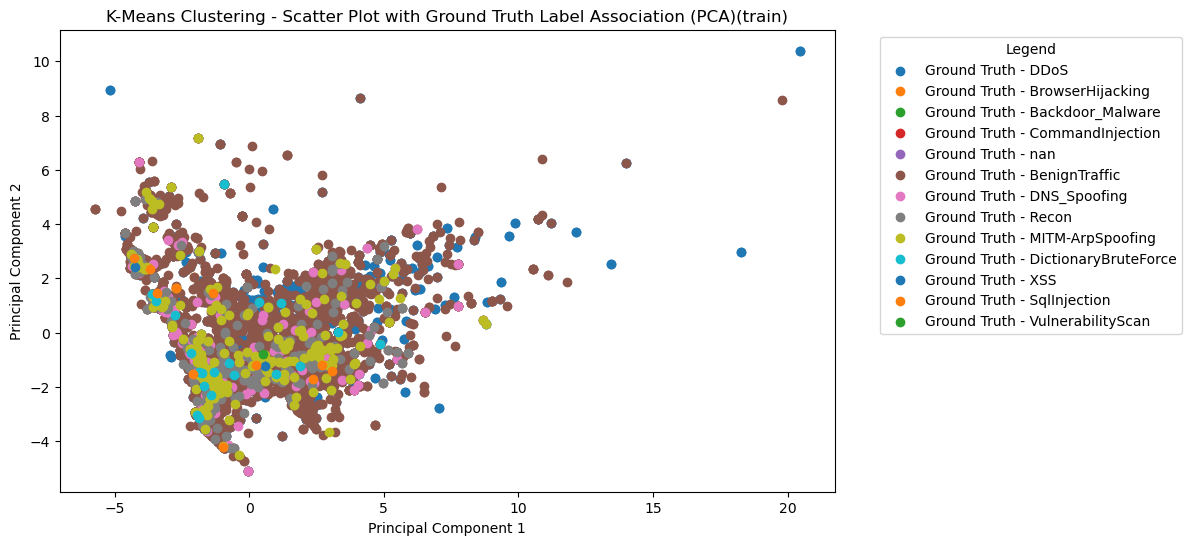

12
13


c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: Benign Ratio = 0.8895238095238095
Cluster 1: Benign Ratio = 0.44940239043824703
Cluster 2: Benign Ratio = 1.0
Cluster 3: Benign Ratio = 0.8142857142857143
Cluster 4: Benign Ratio = 0.5644699140401146
Cluster 5: Benign Ratio = 1.0
Cluster 6: Benign Ratio = 0.9240506329113924
Cluster 7: Benign Ratio = 0.3561643835616438
Cluster 8: Benign Ratio = 1.0
Cluster 9: Benign Ratio = 0.26884226884226886
Cluster 10: Benign Ratio = 0.48186528497409326
Cluster 11: Benign Ratio = 0.8143712574850299
Cluster 12: Benign Ratio = 0.8662952646239555
Cluster 13: Benign Ratio = 1.0
Cluster 14: Benign Ratio = 0.5833333333333334
Cluster 15: Benign Ratio = 0.25594149908592323
Cluster 16: Benign Ratio = 0.7142857142857143
Cluster 17: Benign Ratio = 0.5
Cluster 18: Benign Ratio = 0.85
Cluster 19: Benign Ratio = 0.6615384615384615
Cluster 20: Benign Ratio = 0.8421052631578947
Cluster 21: Benign Ratio = 0.7440860215053764
Threshold: 0.01, False Positive Rate (FPR): 0.12659828579457635
Clusters Labeled as

NameError: name 'inertia5_model2' is not defined

In [27]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

def scenario_5a():
    X = X_test
    y_true = y_test['label']
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_train = scaler.fit_transform(X_train)
    
    # Apply PCA for dimensionality reduction to 2 components
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    X_pca_train = pca.fit_transform(X_scaled_train)
    
    # Apply k-means clustering on the reduced dataset
    # Assuming X_pca_train is a NumPy array
    nan_count = np.isnan(X_pca_train).sum()
    
    print(f"Number of NaN elements in X_pca_train: {nan_count}")
    # MAIN CHANGE!!
    number_of_clusters = 22
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
    predicted_labels_train_data = kmeans.fit(X_scaled_train)
    predicted_labels_train = kmeans.predict(X_scaled_train)
    predicted_labels = kmeans.predict(X_scaled)
    
    #inertia
    inertia5_model2 = kmeans.inertia_
    print("Inertia (Model 5):", inertia5_model2)
    
    #silheoutte
    silhouette_score5_model2 = silhouette_score(X, y_true)
    print("Silhouette Score (Model 5):", silhouette_score5_model2)
    
    # Calculate Calinski-Harabasz Index
    calinski_harabasz5_model2= calinski_harabasz_score(X, y_true)
    print("Calinski-Harabasz Index (Model 5):", calinski_harabasz5_model2)
    
    # Calculate Davies-Bouldin Index
    davies_bouldin5_model2 = davies_bouldin_score(X, y_true)
    print("Davies-Bouldin Index (Model 5):", davies_bouldin5_model2)
    
    # Create a DataFrame to store the association between clusters and ground truth labels
    cluster_label_association = pd.DataFrame({'Cluster': predicted_labels, 'Ground Truth Label': y_true})
    cluster_label_association_train = pd.DataFrame({'Cluster': predicted_labels_train, 'Ground Truth Label': y})
    
    # Plot the association using a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot data points without label names
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis', marker='o', edgecolors='k', label='Clustered Data')
    
    # Create a legend with cluster numbers
    legend_labels = list(range(number_of_clusters))
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.show()
    
    # Plot the association using a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Plot data points without label names
    scatter = plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=predicted_labels_train, cmap='viridis', marker='o', edgecolors='k', label='Clustered Data')
    
    # Create a legend with cluster numbers
    legend_labels = list(range(number_of_clusters))
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA) (train)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.show()
    
    # Plot the association using a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Iterate over unique ground truth labels
    for label in y_true.unique():
        indices = cluster_label_association[cluster_label_association['Ground Truth Label'] == label].index
        plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Ground Truth - {label}')
    
    # Add legend
    plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.show()
    print(cluster_label_association_train.size)
    print(X_pca_train.size)
    # Plot the association using a scatter plot
    plt.figure(figsize=(10, 6))
    
    # Iterate over unique ground truth labels
    for label in y_train.unique():
        indices = cluster_label_association_train[cluster_label_association_train['Ground Truth Label'] == label].index
        indices = indices[indices < X_pca_train.shape[0]]
        print(f'Label: {label}, Indices: {indices}, X_pca_train shape: {X_pca_train.shape}')
        plt.scatter(X_pca_train[indices, 0], X_pca_train[indices, 1], label=f'Ground Truth - {label}')
    
    # Add legend
    plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('K-Means Clustering - Scatter Plot with Ground Truth Label Association (PCA)(train)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.show()
    
    print(y_true.unique().size)
    print(y_train.unique().size)



    # Fit K-Means model to the training data
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
    train_predicted_labels = kmeans.fit_predict(train_data)

    scaled_test_data = scaler.transform(test_data)

    # Predict the clusters for the test data
    cluster_labels_test = kmeans.predict(test_data)

    # Calculate the percentage of benign traffic in each cluster for the training set
    cluster_benign_ratio_train = {}

    benign_class_label = 'BenignTraffic'

    for cluster_label in range(number_of_clusters): 
        cluster_mask = (train_predicted_labels == cluster_label)
        
        # Calculate the denominator
        denominator = np.sum(cluster_mask)
        
        # Check if the denominator is greater than zero before performing the division
        if denominator > 0:
            cluster_benign_ratio_train[cluster_label] = np.sum(y_train[cluster_mask] == benign_class_label) / denominator
        else:
            cluster_benign_ratio_train[cluster_label] = 0  # or any other value you consider appropriate
    for cluster_label, benign_ratio in cluster_benign_ratio_train.items():
        print(f"Cluster {cluster_label}: Benign Ratio = {benign_ratio}")

    test_data_indices = range(len(y_true))
    # adjust this threshold based on the criteria
    benign_thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99]
    fpr_values = {}
    for threshold in benign_thresholds:
        clusters_labeled_as_benign = [cluster_label for cluster_label, ratio in cluster_benign_ratio_train.items() if ratio > threshold]

        false_positive_indices = [idx for idx in test_data_indices if cluster_labels_test[idx] in clusters_labeled_as_benign and y_true[idx] != benign_class_label]

        fpr = len(false_positive_indices) / len(test_data_indices)
        print(f"Threshold: {threshold}, False Positive Rate (FPR): {fpr}")
        print("Clusters Labeled as Benign:", clusters_labeled_as_benign)
        num_clusters_labeled_as_benign = len(clusters_labeled_as_benign)
        print("Number of Clusters Labeled as Benign:", num_clusters_labeled_as_benign)
        print("False Positive Indices:", false_positive_indices)
        print("\n")

    fpr_df2 = pd.DataFrame({
            'Threshold': list(fpr_values.keys()),
            'FPR': list(fpr_values.values())
        })
    return fpr_df2, inertia5_model2, silhouette_score5_model2, calinski_harabasz5_model2, davies_bouldin5_model2, cluster_label_association, cluster_label_association_train

fpr_df2, inertia5_model2, silhouette_score5_model2, calinski_harabasz5_model2, davies_bouldin5_model2, cluster_label_association, cluster_label_association_train = scenario_5a()
print("FPR DataFrame:")
print(fpr_df2)

In [ ]:
cluster_label_association

,Cluster,Ground Truth Label
0,6,BenignTraffic
1,0,Recon
2,5,BenignTraffic
3,20,BenignTraffic
4,20,BenignTraffic
...,...,...
7112,16,BenignTraffic
7113,10,BenignTraffic
7114,2,BenignTraffic
7115,20,BenignTraffic


In [ ]:
cluster_gtl_counts = cluster_label_association.groupby('Cluster')['Ground Truth Label'].value_counts().unstack(fill_value=0)

In [ ]:
cluster_gtl_counts_train = cluster_label_association_train.groupby('Cluster')['Ground Truth Label'].value_counts().unstack(fill_value=0)

In [ ]:
print(cluster_gtl_counts)
print(cluster_gtl_counts_train)

Ground Truth Label  BenignTraffic  BrowserHijacking  CommandInjection  DDoS  \
Cluster                                                                       
0                             215                 2                 0     1   
1                             866                 0                 0     0   
2                             422                 0                 0     0   
3                             376                 3                 0     0   
4                             146                 0                 0     0   
5                             345                 1                 0     0   
6                             280                 0                 0     0   
7                               2                 0                 0     0   
9                              58                 0                 0     0   
10                            961                 0                 0     0   
11                            204                 0 

In [ ]:
cluster_b_ratio = (cluster_gtl_counts['BenignTraffic'] / cluster_gtl_counts.sum(axis=1)).fillna(0)

print(cluster_b_ratio)
cluster_b_ratio_train = (cluster_gtl_counts_train['BenignTraffic'] / cluster_gtl_counts_train.sum(axis=1)).fillna(0)

print("Training result - ", cluster_b_ratio_train)

Cluster
0     0.746528
1     0.989714
2     0.888421
3     0.808602
4     0.924051
5     0.875635
6     0.992908
7     0.222222
9     0.920635
10    0.994824
11    0.775665
12    0.000000
13    0.000000
15    0.989899
16    0.788168
17    0.600000
18    0.771812
19    0.823681
20    0.787879
21    0.690909
dtype: float64
Training result -  Cluster
0     0.862305
1     0.988172
2     0.892758
3     0.837449
4     0.945064
5     0.867400
6     0.969136
7     0.800000
8     0.333333
9     0.794326
10    0.984897
11    0.774283
12    0.000000
13    0.275862
14    0.500000
15    0.976008
16    0.828318
17    0.855670
18    0.787485
19    0.872051
20    0.828396
21    0.894340
dtype: float64


In [ ]:
X_train = train_data
y_train = train_label['label']

# Specify the number of clusters
number_of_clusters = 22  # Adjust as needed

# Fit K-Means model to the training data
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
train_predicted_labels = kmeans.fit_predict(train_data)

scaled_test_data = scaler.transform(test_data)

# Predict the clusters for the test data
cluster_labels_test = kmeans.predict(test_data)

# Calculate the percentage of benign traffic in each cluster for the training set
cluster_benign_ratio_train = {}

benign_class_label = 'BenignTraffic'

for cluster_label in range(number_of_clusters): 
    cluster_mask = (train_predicted_labels == cluster_label)
    
    # Calculate the denominator
    denominator = np.sum(cluster_mask)
    
    # Check if the denominator is greater than zero before performing the division
    if denominator > 0:
        cluster_benign_ratio_train[cluster_label] = np.sum(y_train[cluster_mask] == benign_class_label) / denominator
    else:
        cluster_benign_ratio_train[cluster_label] = 0  # or any other value you consider appropriate
for cluster_label, benign_ratio in cluster_benign_ratio_train.items():
    print(f"Cluster {cluster_label}: Benign Ratio = {benign_ratio}")

test_data_indices = range(len(y_true))
# adjust this threshold based on the criteria
benign_thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99]

for threshold in benign_thresholds:
    clusters_labeled_as_benign = [cluster_label for cluster_label, ratio in cluster_benign_ratio_train.items() if ratio > threshold]

    false_positive_indices = [idx for idx in test_data_indices if cluster_labels_test[idx] in clusters_labeled_as_benign and y_true[idx] != benign_class_label]

    fpr = len(false_positive_indices) / len(test_data_indices)
    print(f"Threshold: {threshold}, False Positive Rate (FPR): {fpr}")
    print("Clusters Labeled as Benign:", clusters_labeled_as_benign)
    num_clusters_labeled_as_benign = len(clusters_labeled_as_benign)
    print("Number of Clusters Labeled as Benign:", num_clusters_labeled_as_benign)
    print("False Positive Indices:", false_positive_indices)
    print("\n")



c:\Users\aravi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: Benign Ratio = 0.8818043395508184
Cluster 1: Benign Ratio = 0.9564293304994687
Cluster 2: Benign Ratio = 0.9830050212437235
Cluster 3: Benign Ratio = 0.9272433306386418
Cluster 4: Benign Ratio = 0.9197080291970803
Cluster 5: Benign Ratio = 0.959493670886076
Cluster 6: Benign Ratio = 0.9941656942823804
Cluster 7: Benign Ratio = 0.889196675900277
Cluster 8: Benign Ratio = 0.8858385430823593
Cluster 9: Benign Ratio = 0.9375
Cluster 10: Benign Ratio = 0.9636617749825297
Cluster 11: Benign Ratio = 1.0
Cluster 12: Benign Ratio = 0.7640449438202247
Cluster 13: Benign Ratio = 0.9863163656267104
Cluster 14: Benign Ratio = 0.8283261802575107
Cluster 15: Benign Ratio = 1.0
Cluster 16: Benign Ratio = 0.7709466811751904
Cluster 17: Benign Ratio = 1.0
Cluster 18: Benign Ratio = 0.9591836734693877
Cluster 19: Benign Ratio = 0.984919396775871
Cluster 20: Benign Ratio = 0.9737470167064439
Cluster 21: Benign Ratio = 0.8994340444057466
Threshold: 0.01, False Positive Rate (FPR): 0.126598285794